# Credit Card Fraud Detection

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().values.any()

False

### Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

Text(0, 0.5, 'Frequency')

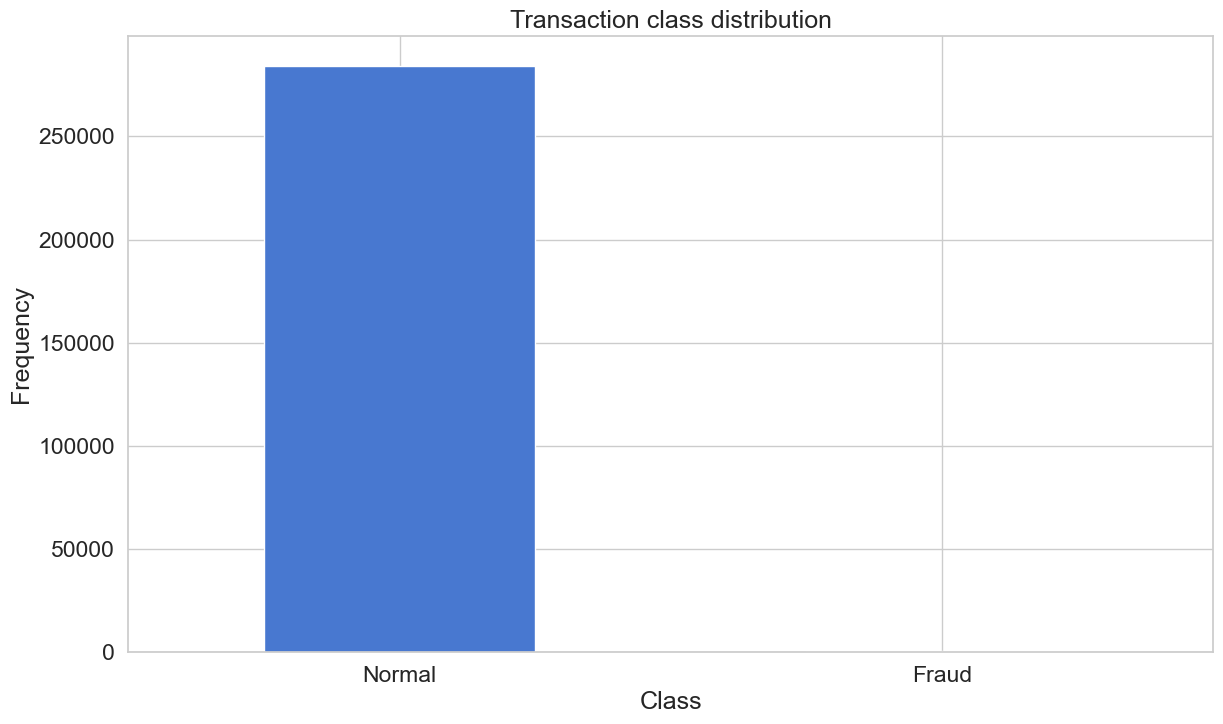

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [7]:
normal.shape

(284315, 31)

### Checking the amount of money involved in each kind of transaction

In [8]:
# Fraud transactions
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
# Non-fraud transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

### Graphical representation of Amount

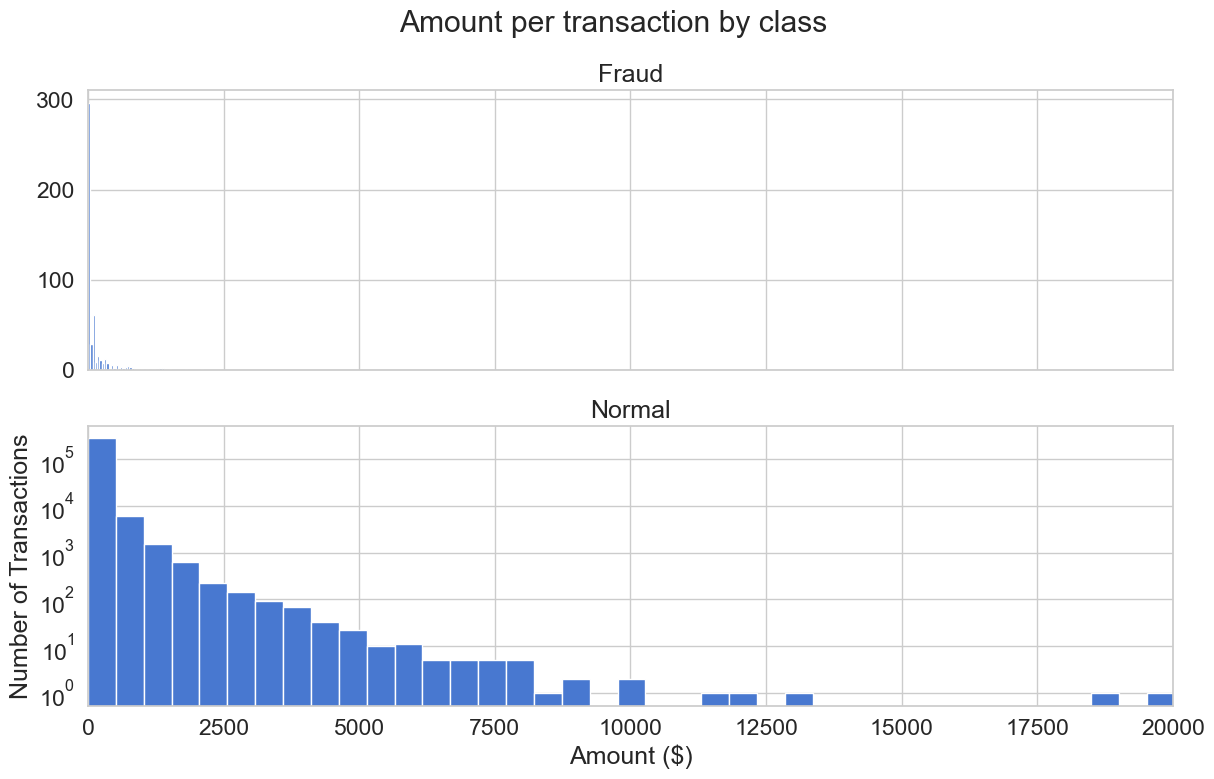

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### Plotting time of transaction to check for correlations

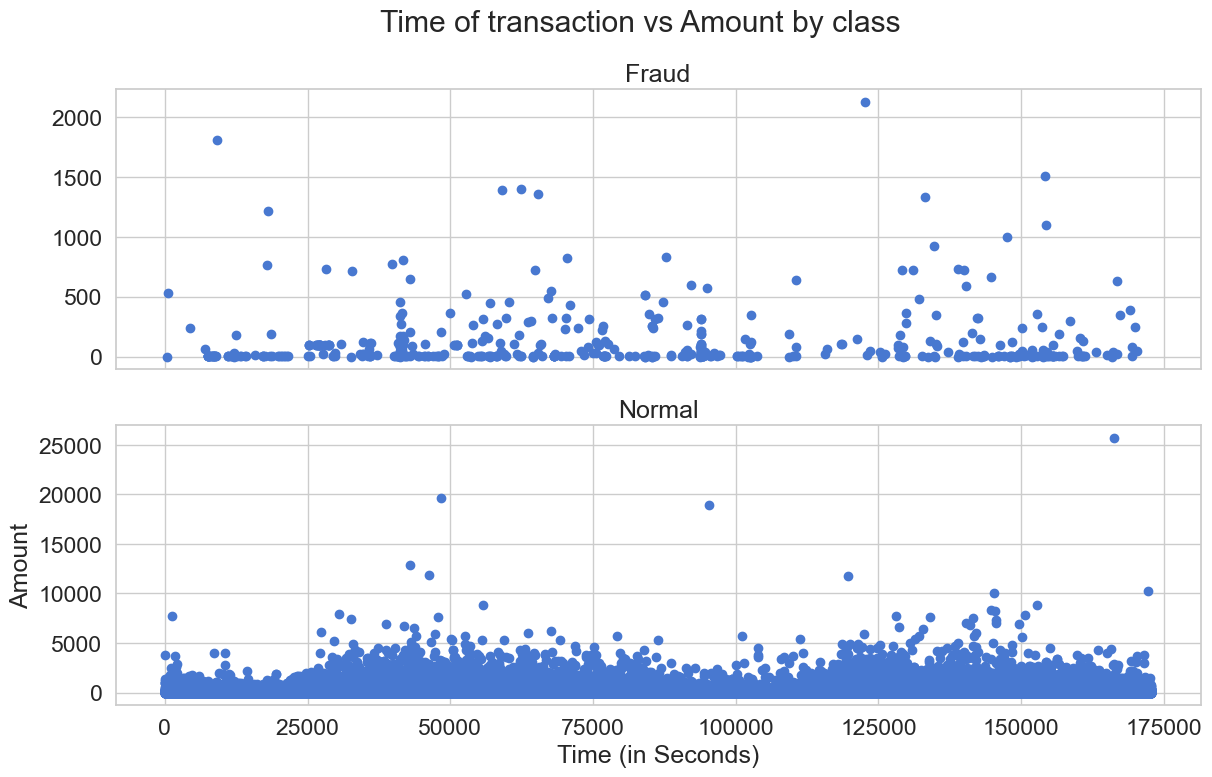

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
data = df.drop(['Time'], axis=1)

### Scaling the Amount using StandardScaler

In [13]:
from sklearn.preprocessing import StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

### Building the model

In [17]:
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

df = non_fraud._append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

### Splitting the data into 80% training data and 20% testing data

In [19]:
xtrain, xtest = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
xtrain_fraud = xtrain[xtrain.Class == 1]
xtrain = xtrain[xtrain.Class == 0]
xtrain = xtrain.drop(['Class'], axis=1)
ytest = xtest['Class']
xtest = xtest.drop(['Class'], axis=1)
xtrain = xtrain.values
xtest = xtest.values
xtrain.shape

(227451, 29)

### Autoencoder model

In [20]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

### Training the credit card fraud detection model

In [21]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

### Scaling the values

In [22]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10

7/7 [==============================] - 10s 165ms/step - loss: 0.2656 - val_loss: 0.2651
Epoch 2/10
7/7 [==============================] - 0s 29ms/step - loss: 0.2652 - val_loss: 0.2648
Epoch 3/10
7/7 [==============================] - 0s 32ms/step - loss: 0.2649 - val_loss: 0.2644
Epoch 4/10
7/7 [==============================] - 1s 90ms/step - loss: 0.2645 - val_loss: 0.2641
Epoch 5/10
7/7 [==============================] - 1s 92ms/step - loss: 0.2642 - val_loss: 0.2637
Epoch 6/10
7/7 [==============================] - 1s 111ms/step - loss: 0.2638 - val_loss: 0.2634
Epoch 7/10
7/7 [==============================] - 1s 86ms/step - loss: 0.2635 - val_loss: 0.2630
Epoch 8/10
7/7 [==============================] - 0s 26ms/step - loss: 0.2631 - val_loss: 0.2626
Epoch 9/10
7/7 [==============================] - 0s 23ms/step - loss: 0.2627 - val_loss: 0.2623
Epoch 10/10
7/7 [==============================] - 0s 31ms/step - loss: 0.2624 - val_loss: 0.2619


### Obtain the hidden representation

In [23]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

### Model prediction

In [24]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 6ms/step


### Getting the representation data

In [25]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

### Train, Test, Split

In [26]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

### Credit card fraud detection prediction model

In [27]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       741
         1.0       1.00      0.77      0.87       132

    accuracy                           0.96       873
   macro avg       0.98      0.88      0.92       873
weighted avg       0.97      0.96      0.96       873


Accuracy Score:  0.9644902634593356
